## Test01_2 MNE

เปลี่ยนการเขียน csp และก่อนเข้า csp ลองแยก split

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals - 1398.18 Baht

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

**Planning: Use only 1 subjects for testing code.**

1. Read all .set files, find only S1R1 - S1R10
2. merge the files in to 1 set
3. Preprocessing (Fliter + Baseline correction + Epoching)
4. Epoching only Flexion and Extension 

In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne import concatenate_epochs
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from IPython.display import display

#### Step 1: READ Dataset 

- read only S1R1 - S1R10
- rename label from 'elbow flexion' to 'S1R1_elbow flexion' for easy to concat

In [2]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

In [3]:
subjects = [1]

# Label 6 classes
label_map = {
    'forearm supination': 0,
    'forearm pronation': 1,
    'shoulder adduction': 2,
    'shoulder abduction': 3,
    'elbow extension': 4,
    'elbow flexion': 5
}

# Helper สำหรับเรียง Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
EpochList = []
y_all = []

# Load ทุก Subject และ Run
for s in subjects:
    for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
        if file_name.startswith(f"S{s}R") and file_name.endswith(".set"):
            path = os.path.join(DataFolder, file_name)
            print(f"Reading {file_name}...")

            try:
                # Load .set
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')

                #  สร้าง mapping ชื่อ event เดิม (เช่น S1R1_elbow flexion)
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                #  รีแมพทุก event ใหม่ให้ match กับ label_map
                new_events = []
                selected_labels = []

                for i, (onset, _, eid) in enumerate(epochs.events):
                    event_name = id_to_name[eid].split('_')[-1]
                    if event_name in label_map:
                        new_eid = label_map[event_name]
                        new_events.append([onset, 0, new_eid])
                        selected_labels.append(new_eid)

                if new_events:
                    # 📎 สร้าง Epochs ใหม่ด้วย event ที่รีแมพแล้ว
                    new_events = np.array(new_events)
                    epochs.events = new_events
                    epochs.event_id = label_map.copy()

                    # เฉพาะ epoch ที่เราใช้จริง
                    EpochList.append(epochs)
                    y_all.extend(selected_labels)

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมเป็นก้อนเดียวแบบปลอดภัย
combined_epochs = concatenate_epochs(EpochList)
X_all = combined_epochs.get_data()
y_all = np.array(y_all)

# สรุป
print("\n รวมข้อมูลเสร็จแล้ว:")
print(" X shape (n_epochs, n_channels, n_times): ", X_all.shape)         # (n_epochs, n_channels, n_times)
print(" y shape (n_epochs):", y_all.shape)         # (n_epochs,)
print(" Label counts (0–5):", np.bincount(y_all))


Reading S1R1.set...
Reading S1R2.set...
Reading S1R3.set...
Reading S1R4.set...
Reading S1R5.set...
Reading S1R6.set...
Reading S1R7.set...
Reading S1R8.set...
Reading S1R9.set...
Reading S1R10.set...
Not setting metadata
1800 matching events found
No baseline correction applied

 รวมข้อมูลเสร็จแล้ว:
 X shape (n_epochs, n_channels, n_times):  (1800, 16, 1500)
 y shape (n_epochs): (1800,)
 Label counts (0–5): [300 300 300 300 300 300]


##### Test Combined Epochs

In [4]:
combined_epochs

<EpochsArray | 1800 events (all good), -1 – 1.998 s (baseline off), ~329.6 MiB, data loaded,
 'forearm supination': 300
 'forearm pronation': 300
 'shoulder adduction': 300
 'shoulder abduction': 300
 'elbow extension': 300
 'elbow flexion': 300>

In [5]:
#Check Overview and each epoch name
overviewpic = combined_epochs.plot(n_epochs=3,events=True, event_id = True)

# Plot each epoch name
for i in range(len(combined_epochs)):
    event_id = combined_epochs.events[i, 2]
    label = [k for k, v in combined_epochs.event_id.items() if v == event_id]
    print(f"Epoch {i}: {label[0] if label else 'Unknown'}")


Using matplotlib as 2D backend.


Epoch 0: forearm supination
Epoch 1: elbow extension
Epoch 2: forearm pronation
Epoch 3: shoulder adduction
Epoch 4: shoulder adduction
Epoch 5: shoulder abduction
Epoch 6: forearm pronation
Epoch 7: shoulder adduction
Epoch 8: forearm pronation
Epoch 9: elbow extension
Epoch 10: forearm pronation
Epoch 11: elbow extension
Epoch 12: forearm supination
Epoch 13: elbow extension
Epoch 14: elbow extension
Epoch 15: forearm supination
Epoch 16: forearm pronation
Epoch 17: shoulder adduction
Epoch 18: shoulder abduction
Epoch 19: forearm supination
Epoch 20: forearm pronation
Epoch 21: shoulder adduction
Epoch 22: forearm supination
Epoch 23: shoulder abduction
Epoch 24: elbow extension
Epoch 25: forearm pronation
Epoch 26: forearm supination
Epoch 27: elbow flexion
Epoch 28: shoulder abduction
Epoch 29: forearm supination
Epoch 30: forearm supination
Epoch 31: elbow flexion
Epoch 32: elbow extension
Epoch 33: shoulder abduction
Epoch 34: elbow extension
Epoch 35: shoulder adduction
Epoch 3

In [6]:
#Check sensor location
SensorPic = combined_epochs.plot_sensors(show_names=True, sphere =0.125) #ยิ่งเพิ่มยิ่งลดขนาด

### Step 2: Bandpass Filter

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.5s
[Parallel(n_job

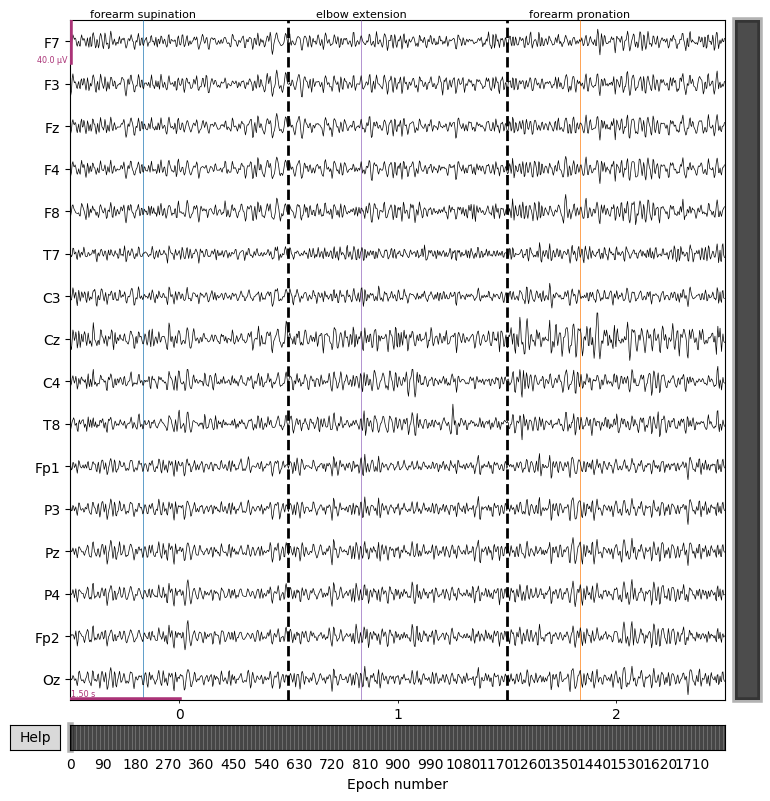

In [7]:
#copy old dataset
copy_combined = combined_epochs.copy()

#Apply bandpass
filtered_epochs = copy_combined.filter(l_freq=8.0, h_freq=30.0)

figfilter = filtered_epochs.plot(n_epochs=3, events=True, event_id=True)

### Check Bandpass

In [8]:
print("High-pass:", filtered_epochs.info['highpass'])
print("Low-pass :", filtered_epochs.info['lowpass'])

High-pass: 8.0
Low-pass : 30.0


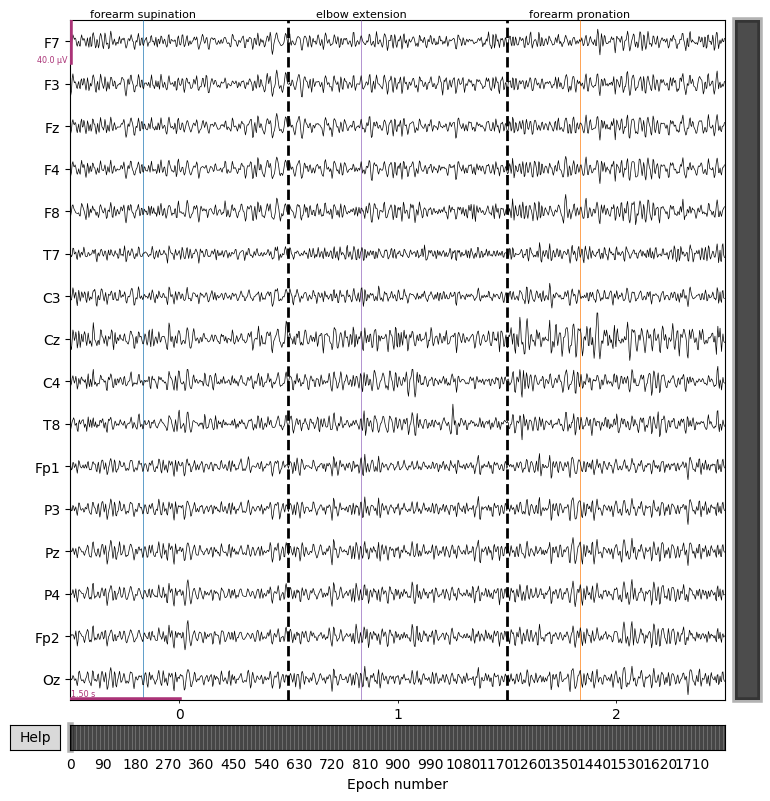

In [9]:
filteredpic = filtered_epochs.plot(n_epochs=3,events=True, event_id = True)

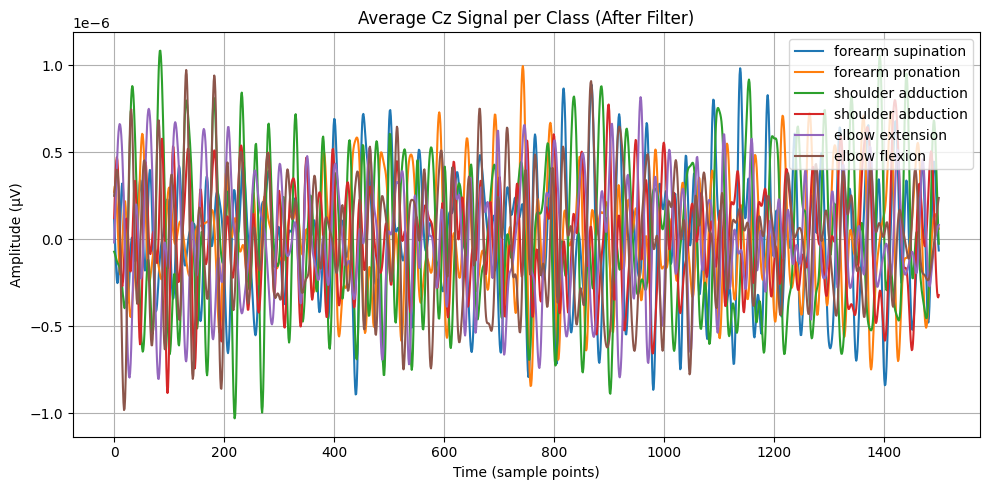

In [10]:
#ดู mean signal (channel เช่น Cz) เปรียบเทียบแต่ละคลาส
cz_idx = filtered_epochs.ch_names.index('Cz')
X_bandpassed = filtered_epochs.get_data()  # เอา data ออกมาจาก filtered_epochs

plt.figure(figsize=(10,5))

for class_id in np.unique(y_all):
    class_name = list(label_map.keys())[class_id]
    mean_signal = X_bandpassed[y_all == class_id, cz_idx, :].mean(axis=0)
    plt.plot(mean_signal, label=class_name)

plt.title("Average Cz Signal per Class (After Filter)")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# #ดูพลังงานรวมของแต่ละ clas
# energy = [np.mean(np.square(filtered_epochs[y_all == i])) for i in range(6)]
# classes = list(label_map.keys())

# plt.bar(classes, energy)
# plt.ylabel("Average Energy")
# plt.title("Signal Energy per Class (8–30 Hz)")
# plt.xticks(rotation=30)
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


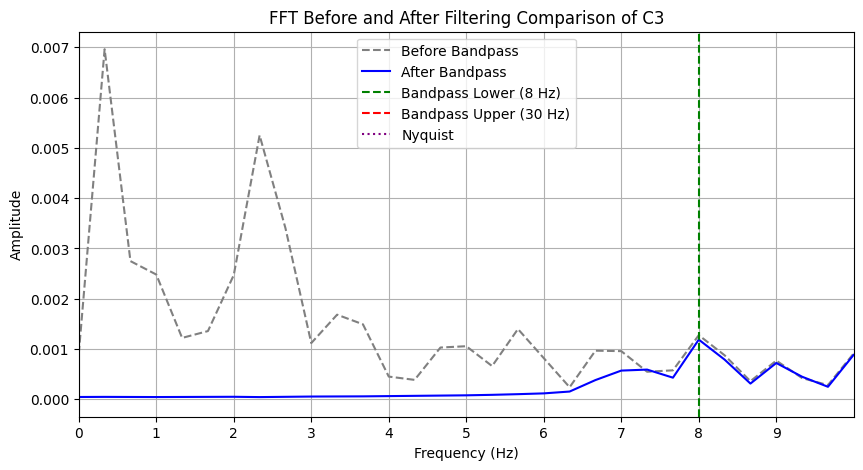

In [12]:
#Plot fft
channel_nam = 'C3'
channel_id = combined_epochs.ch_names.index(channel_nam)  # ก่อน filter
fis = combined_epochs.info['sfreq']

# สัญญาณก่อน filter
signal_before = combined_epochs.get_data()[0, channel_id, :]
# สัญญาณหลัง filter
signal_after = filtered_epochs.get_data()[0, channel_id, :]

# FFT
nu = len(signal_after)
freqs = np.fft.rfftfreq(nu, 1/fis)
fft_before = np.abs(np.fft.rfft(signal_before))
fft_after = np.abs(np.fft.rfft(signal_after))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_before, label="Before Bandpass", color='gray', linestyle='--')
plt.plot(freqs, fft_after, label="After Bandpass", color='blue')
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fis/2, color='purple', linestyle=':', label='Nyquist')

plt.title(f"FFT Before and After Filtering Comparison of {channel_nam}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
# plt.xlim(0, fs / 2)
# plt.ylim(0, 0.0015)  
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))  # ticks each 1 Hz
# plt.ylim(0,0.005)
# plt.yticks(np.arange(0, 0.005, 0.001))  # ticks each 1 Hz
plt.show()


### Step 3: Downsampling

In [13]:
downsampled_epochs = filtered_epochs.copy().resample(128)#128 100
downsampled_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 128.0 Hz
>

### Check Downsampling

In [14]:
#FFT method Before

# Pick channel
chan_namee = 'Cz'
chan_indexx = filtered_epochs.ch_names.index(chan_namee)

# Get signal
ss = filtered_epochs.get_data()[0, chan_indexx, :]
fss = filtered_epochs.info['sfreq']

# FFT
nn = len(ss)
freqss = np.fft.rfftfreq(nn, 1/fss)
fft_valss = np.abs(np.fft.rfft(ss))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqss, fft_valss, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fss/2, color='red', linestyle='--', label=f'Nyquist ({fss/2:.1f} Hz)')
plt.title(f"Before Downsampling |filtered| FFT Graph of {chan_namee} (Sampling Rate = {fss} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0, 270)
plt.xticks(np.arange(0, 270, 25))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
#FFT method after

# Pick channel
chan_name = 'Cz'
chan_index = downsampled_epochs.ch_names.index(chan_name)

# Get signal
s = downsampled_epochs.get_data()[0, chan_index, :]
fs = downsampled_epochs.info['sfreq']

# FFT
n = len(s)
freqs = np.fft.rfftfreq(n, 1/fs)
fft_vals = np.abs(np.fft.rfft(s))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_vals, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
plt.title(f"After Downsampling |downsampled_epochs| FFT Graph of {chan_name} (Sampling Rate = {fs} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0,70)
plt.xticks(np.arange(0, 70, 5))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Step 4: ICA

In [16]:
#make a goddam copy
ICAprocess = downsampled_epochs.copy()

#ICA Object
ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter='auto')

#Fit ICA
ica.fit(ICAprocess)

#PlotComponents: topomap and layout
fig = ica.plot_components(colorbar=True)

#Label components using MNE ICALabel
labels = label_components(ICAprocess, ica, method='iclabel')
for i, label in enumerate(labels['labels']):
    print(f"Component {i}: {label}")

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 6.6s.


C:\Users\HP\AppData\Local\Temp\ipykernel_25008\673093396.py:14: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_25008\673093396.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_25008\673093396.py:14: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the e

Component 0: heart beat
Component 1: brain
Component 2: brain
Component 3: brain
Component 4: brain
Component 5: brain
Component 6: brain
Component 7: brain
Component 8: brain
Component 9: heart beat
Component 10: heart beat
Component 11: heart beat
Component 12: brain
Component 13: brain
Component 14: brain
Component 15: brain


In [17]:
#Delete components except brain
exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ['eye', 'muscle', 'heart beat']]
# ica.exclude = [0,8,9,10,14]

#Make a copy and Apply ICA
# CleanAlready = ICAprocess.copy()
# ica.apply(CleanAlready)
CleanAlready = ica.apply(ICAprocess, exclude = exclude_idx)

Applying ICA to Epochs instance
    Transforming to ICA space (16 components)
    Zeroing out 4 ICA components
    Projecting back using 16 PCA components


### Check ICA

In [18]:
print("Excluded ICA components:", exclude_idx)

Excluded ICA components: [0, 9, 10, 11]


- compare before vs after overview

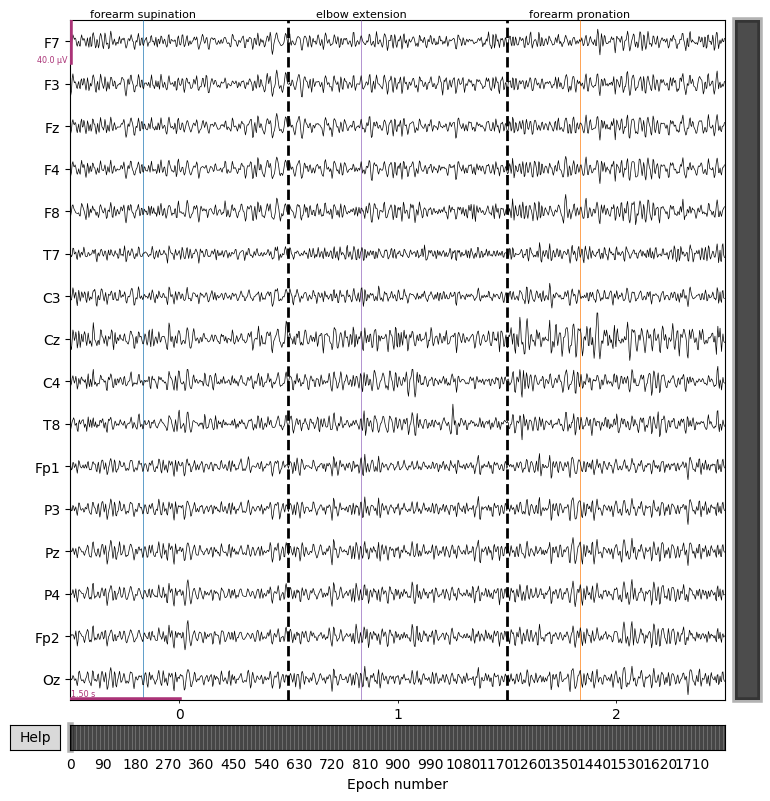

In [19]:
filteredpic = filtered_epochs.plot(n_epochs=3,events=True, event_id = True)

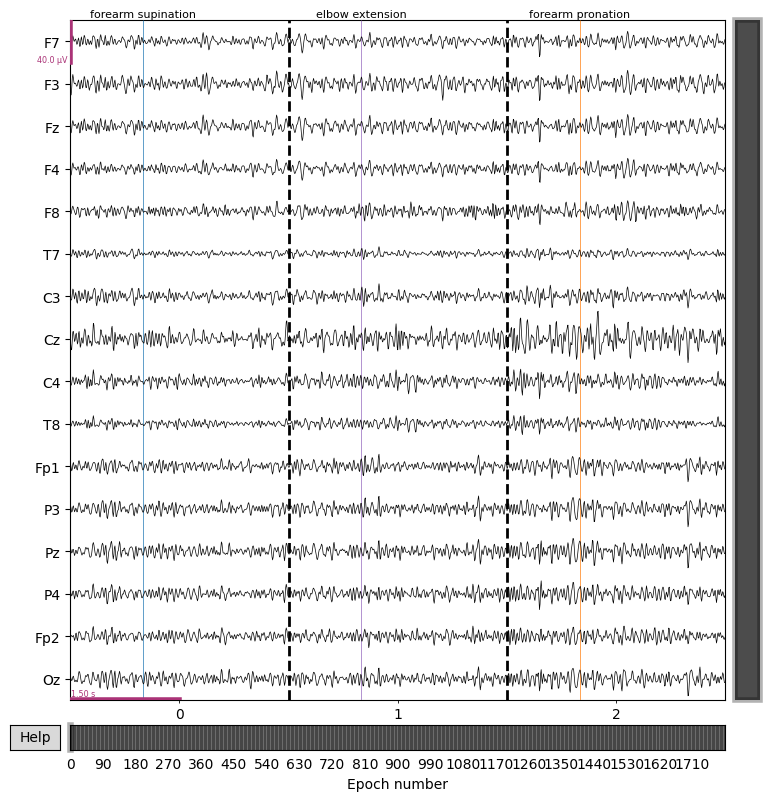

In [20]:
cleanpic = CleanAlready.plot(n_epochs=3,events=True, event_id = True)

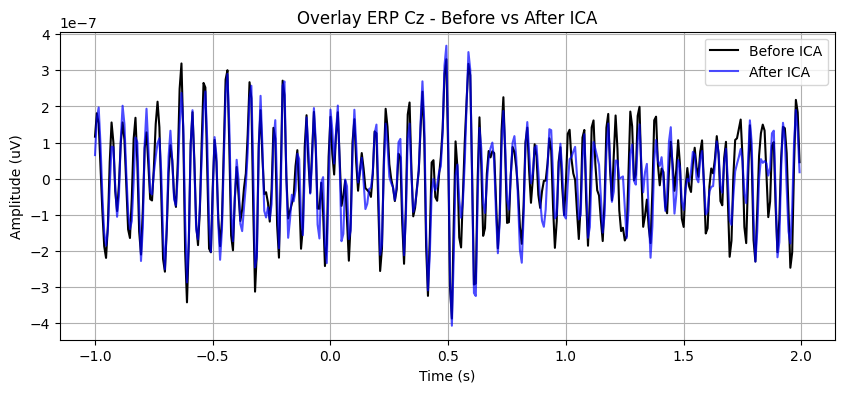

In [21]:
#Check ERP waveform
before0 = downsampled_epochs.average()
after0 = CleanAlready.average()

#overlay graph with matplotlib
chn_name = 'Cz'
plt.figure(figsize=(10, 4))
plt.plot(before0.times, before0.data[before0.ch_names.index(chn_name)], label='Before ICA', color='black')
plt.plot(after0.times, after0.data[after0.ch_names.index(chn_name)], label='After ICA', color='blue',alpha=0.7 )

plt.title(f"Overlay ERP {chn_name} - Before vs After ICA")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.grid(True)
plt.legend()
plt.show()


### Step 5: Epoching&Baseline Correction

In [22]:
#Chek if the dataset is done it
print(CleanAlready.baseline)

None


In [23]:
#Epoching
target_classes = [
    'forearm supination',
    'elbow extension',
    'forearm pronation',
    'shoulder adduction',
    'shoulder abduction',
    'elbow flexion'
]

#Select Class from dataset
Selected_epochs = CleanAlready[target_classes]
Selected_epochs

<EpochsArray | 1800 events (all good), -1 – 1.992 s (baseline off), ~84.4 MiB, data loaded,
 'forearm supination': 300
 'forearm pronation': 300
 'shoulder adduction': 300
 'shoulder abduction': 300
 'elbow extension': 300
 'elbow flexion': 300>

In [24]:
#epoch range
print(Selected_epochs.tmin, Selected_epochs.tmax)

-1.0 1.9921875


In [25]:
#Baseline Correction

#backup
Selectedtuna = Selected_epochs.copy()

Selectedtuna.apply_baseline(baseline=(-0.5, 0))
print("Baseline applied:", Selectedtuna.baseline)
print("Epoch shape:", Selectedtuna.get_data().shape)  # (n_epochs, n_channels, n_times)

Applying baseline correction (mode: mean)
Baseline applied: (-0.5, 0.0)
Epoch shape: (1800, 16, 384)


### Check Baseline Correction

In [26]:
#Check Before After
before = Selected_epochs.copy().get_data()
after = Selectedtuna.get_data()
print(np.allclose(before, after))  #False = applied

False


In [27]:
#Check offset
before = Selected_epochs.copy().get_data()
after = Selectedtuna.get_data()

print(np.mean(before)) 
print(np.mean(after))    #should near 0


1.877103124246471e-10
-7.712438561045668e-10


In [28]:
#FFT plot

# ตั้งค่าเบื้องต้น
c_name = 'Cz'
c_index = Selected_epochs.ch_names.index(c_name)
fs = Selected_epochs.info['sfreq']

# ดึงข้อมูลก่อนและหลัง baseline correction
data_before = Selected_epochs.get_data()   # ก่อนทำ baseline
data_after = Selectedtuna.get_data()       # หลังทำ baseline

# จำนวน epoch ที่จะดู
Nu = 5

# เริ่ม plot
plt.figure(figsize=(14, 6))

for i in range(Nu):
    # ก่อน baseline
    sig_before = data_before[i, c_index, :]
    fft_before = np.abs(np.fft.rfft(sig_before))
    
    # หลัง baseline
    sig_after = data_after[i, c_index, :]
    fft_after = np.abs(np.fft.rfft(sig_after))
    
    freqs = np.fft.rfftfreq(len(sig_before), 1/fs)
    
    # Plot ทั้งสอง
    plt.plot(freqs, fft_before, label=f'Before Baseline Epoch {i+1}', linestyle='--', alpha=0.7, color='skyblue')
    plt.plot(freqs, fft_after, label=f'After Baseline Epoch {i+1}', linestyle='-', alpha=0.9, color='orange')

# Optional: เส้นอ้างอิง
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fs/2, color='purple', linestyle=':', label='Nyquist')

# การตั้งค่ากราฟ
plt.title(f"FFT Comparison Before vs After Baseline Correction ({c_name})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0,3)
plt.xticks(np.arange(0, 3, 1))  # ticks each 1 Hz
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [29]:
# ก่อน
mean_before = np.mean(Selected_epochs.get_data(), axis=2)  # (n_epochs, n_channels)
mean_after = np.mean(Selectedtuna.get_data(), axis=2)

# ดูค่าเฉลี่ยรวมทุก channel ทุก epoch
print(" Mean ก่อน baseline correction:", np.mean(mean_before))
print(" Mean หลัง baseline correction:", np.mean(mean_after))


 Mean ก่อน baseline correction: 1.8771031242464722e-10
 Mean หลัง baseline correction: -7.712438561045667e-10


In [30]:
# ตรวจเฉพาะ C3
c_index = Selected_epochs.ch_names.index('C4')
c_mean_before = np.mean(Selected_epochs.get_data()[:, c_index, :])
c_mean_after = np.mean(Selectedtuna.get_data()[:, c_index, :])

print("C4 Mean ก่อน correction:", c_mean_before)
print("C4 Mean หลัง correction:", c_mean_after)


C4 Mean ก่อน correction: 5.353067003304536e-10
C4 Mean หลัง correction: -1.997356395003364e-09


In [31]:
#Check time per epoch
n_times = Selectedtuna.get_data().shape[2]  # จำนวน sample ต่อ 1 epoch
sfreq = Selectedtuna.info['sfreq']          # sampling rate (Hz)

# คำนวณ duration
duration_sec = n_times / sfreq
print(f"Duration per epoch: {duration_sec:.3f} seconds")


Duration per epoch: 3.000 seconds


Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated


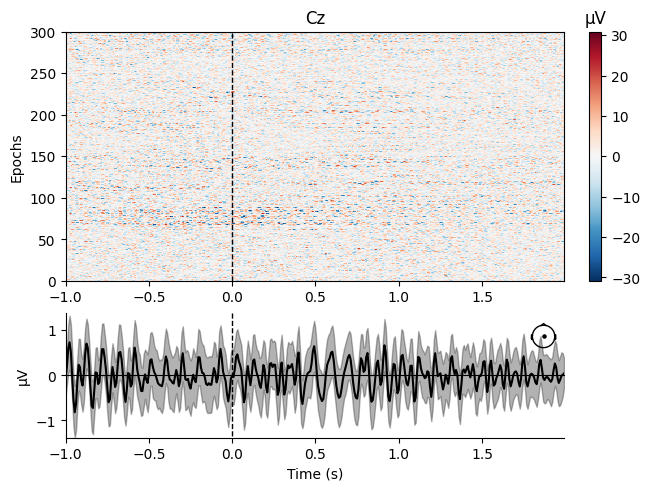

[<Figure size 640x480 with 4 Axes>]

In [32]:
Selectedtuna['elbow extension'].plot_image(picks =[7])

### Step 4: Feature Extraction

- No CSP 

In [33]:
X = Selectedtuna.get_data()  # Shape = (n_epochs, n_channels, n_times)
y = y_all  # From earlier step

# Feature extraction
X_mean = X.mean(axis=2)
X_std = X.std(axis=2)
X_power = np.mean(X**2, axis=2)
X_log_power = np.log(X_power + 1e-6)

# Combine features
X_feat = np.concatenate([X_mean, X_std, X_log_power], axis=1)  # shape = (n_epochs, n_channels * 3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2, random_state=42)

### Step 5: Classification

#### LDA (Linear Discriminant Analysis)


[TEST] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.13      0.34      0.19        50
 forearm pronation       0.24      0.14      0.18        70
shoulder adduction       0.22      0.18      0.20        49
shoulder abduction       0.20      0.26      0.23        53
   elbow extension       0.24      0.08      0.12        74
     elbow flexion       0.20      0.17      0.18        64

          accuracy                           0.19       360
         macro avg       0.21      0.20      0.18       360
      weighted avg       0.21      0.19      0.18       360

[TEST] Confusion Matrix


c:\python3_11_2\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\python3_11_2\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python3_11_2\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\python3_11_2\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  F


[TRAIN] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.21      0.41      0.28       250
 forearm pronation       0.23      0.22      0.23       230
shoulder adduction       0.23      0.17      0.19       251
shoulder abduction       0.23      0.21      0.22       247
   elbow extension       0.33      0.13      0.19       226
     elbow flexion       0.16      0.16      0.16       236

          accuracy                           0.22      1440
         macro avg       0.23      0.22      0.21      1440
      weighted avg       0.23      0.22      0.21      1440

[TRAIN] Confusion Matrix


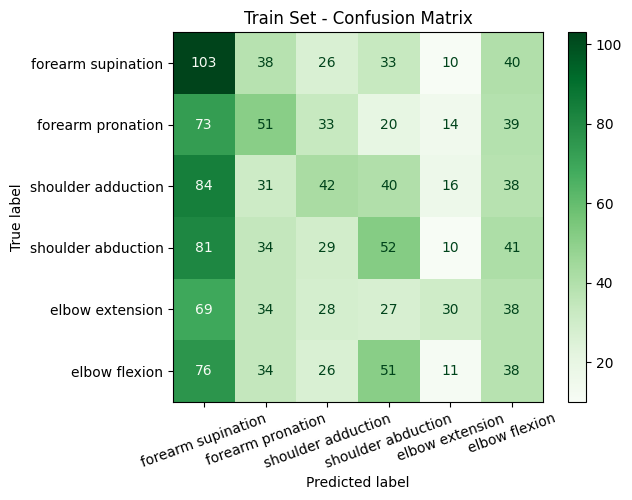

In [34]:
X = X_train
y = y_train
X_test = X_test

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best LDA
lda_pipeline = Pipeline([('clf', LinearDiscriminantAnalysis())])
lda_params = {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', None]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda_grid = GridSearchCV(lda_pipeline, lda_params, cv=cv, scoring='accuracy', n_jobs=-1)
lda_grid.fit(X_train, y_train)

# Final model
best_lda = lda_grid.best_estimator_
best_lda.fit(X_train, y_train)

# ========= TEST SET RESULTS ========= #
y_test_pred = best_lda.predict(X_test)
y_test_proba = best_lda.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(cm_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
disp.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

# ========= TRAIN SET RESULTS ========= #
y_train_pred = best_lda.predict(X_train)
y_train_proba = best_lda.predict_proba(X_train)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
disp.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


#### SVM (Support Vector Machine)


[TEST] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.00      0.00      0.00        50
 forearm pronation       0.00      0.00      0.00        70
shoulder adduction       0.14      1.00      0.24        49
shoulder abduction       0.00      0.00      0.00        53
   elbow extension       0.00      0.00      0.00        74
     elbow flexion       0.00      0.00      0.00        64

          accuracy                           0.14       360
         macro avg       0.02      0.17      0.04       360
      weighted avg       0.02      0.14      0.03       360

[TEST] Confusion Matrix


c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


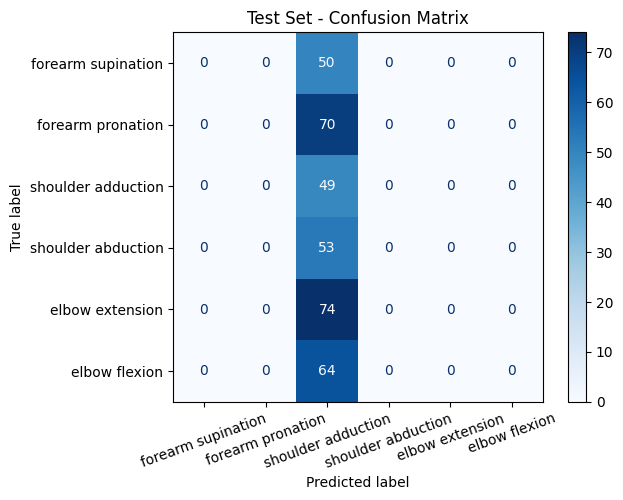


[TRAIN] Classification Report
                    precision    recall  f1-score   support

forearm supination       0.00      0.00      0.00       250
 forearm pronation       0.00      0.00      0.00       230
shoulder adduction       0.17      1.00      0.30       251
shoulder abduction       0.00      0.00      0.00       247
   elbow extension       0.00      0.00      0.00       226
     elbow flexion       0.00      0.00      0.00       236

          accuracy                           0.17      1440
         macro avg       0.03      0.17      0.05      1440
      weighted avg       0.03      0.17      0.05      1440

[TRAIN] Confusion Matrix


c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python3_11_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


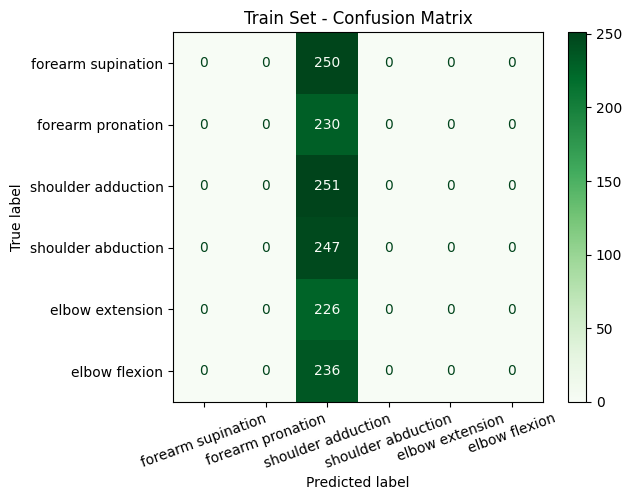

In [35]:
X = X_train
y = y_train
X_test_final = X_test
n_classes = len(np.unique(y))

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best SVM
svm_pipeline = Pipeline([('clf', SVC(probability=True))])  # ต้องเปิด probability=True เพื่อใช้ ROC AUC
svm_params = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']  # เฉพาะ RBF ใช้ gamma
}
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Final model
best_svm = svm_grid.best_estimator_
best_svm.fit(X_train, y_train)

# ========= TEST SET =========
y_test_pred = best_svm.predict(X_test_final)
y_test_proba = best_svm.predict_proba(X_test_final)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
dis = ConfusionMatrixDisplay(cm_test,display_labels=class_n)
dis.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


# ========= TRAIN SET =========
y_train_pred = best_svm.predict(X_train)
y_train_proba = best_svm.predict_proba(X_train)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
dis2 = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
dis2.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()